In [2]:
import json

In [41]:
epsilon = "\u03B5"
alphanumerics = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'

class Edge:
    def __init__(self, label):
        self.label = label

class State:
    def __init__(self,name):
        self.name = name
        self.in_edges = []
        self.out_edges = []

class NFA:
    def __init__(self, char: str, start: State, accepting: State):
        self.states = [start,accepting]
        self.start = start
        self.accepting = accepting

        edge = Edge(char)
        self.start.out_edges.append(edge)
        self.accepting.in_edges.append(edge)

    @staticmethod
    def postfix2NFA(postfix:str):
        stack = []
        state_counter= 0

        for char in postfix:
            if char=='.':
                nfa2 = stack.pop()
                nfa1 = stack.pop()

                edge = Edge(epsilon)
                nfa1.accepting.out_edges.append(edge)
                nfa2.start.in_edges.append(edge)

                concatenated_nfa = NFA(epsilon, nfa1.start, nfa2.accepting)

                concatenated_nfa.states = nfa1.states + nfa2.states
                stack.append(concatenated_nfa)

            elif char=='|':
                nfa2 = stack.pop()
                nfa1 = stack.pop()
                new_start = State('S' + str(state_counter))
                new_accept = State('S' +  str(state_counter +1))
                state_counter += 2
                edge1,edge2,edge3,edge4 = Edge(epsilon),Edge(epsilon),Edge(epsilon),Edge(epsilon)


                new_start.out_edges.append(edge1)
                nfa1.start.in_edges.append(edge1)

                new_start.out_edges.append(edge2)
                nfa2.start.in_edges.append(edge2)

                nfa1.accepting.out_edges.append(edge3)
                new_accept.in_edges.append(edge3)

                nfa2.accepting.out_edges.append(edge4)
                new_accept.in_edges.append(edge4)

                ored_nfa= NFA(epsilon, new_start, new_accept)

                ored_nfa.states = [new_start, new_accept] + nfa1.states + nfa2.states
                stack.append(ored_nfa)

            elif char=='*':
                nfa = stack.pop()
                new_start = State('S' + str(state_counter))
                new_accept = State('S' +  str(state_counter +1))
                state_counter += 2
                edge1,edge2,edge3,edge4 = Edge(epsilon),Edge(epsilon),Edge(epsilon),Edge(epsilon)

                new_start.out_edges.append(edge1)
                nfa.start.in_edges.append(edge1)

                nfa.accepting.out_edges.append(edge2)
                new_accept.in_edges.append(edge2)

                nfa.accepting.out_edges.append(edge3)
                nfa.start.in_edges.append(edge3)

                new_start.out_edges.append(edge4)
                new_accept.in_edges.append(edge4)

                zero_or_more_nfa = NFA(epsilon, new_start, new_accept)
                zero_or_more_nfa.states = [new_start, new_accept] + nfa.states
                stack.append(zero_or_more_nfa)

            elif char=='+':
                nfa = stack.pop()
                new_start = State('S' + str(state_counter))
                new_accept = State('S' +  str(state_counter +1))
                state_counter += 2
                edge1,edge2,edge3 = Edge(epsilon),Edge(epsilon),Edge(epsilon)

                new_start.out_edges.append(edge1)
                nfa.start.in_edges.append(edge1)

                nfa.accepting.out_edges.append(edge2)
                new_accept.in_edges.append(edge2)

                nfa.accepting.out_edges.append(edge3)
                nfa.start.in_edges.append(edge3)

                one_or_more_nfa = NFA(epsilon, new_start, new_accept)
                one_or_more_nfa.states = [new_start, new_accept] + nfa.states
                stack.append(one_or_more_nfa)

            elif char == '?':
                nfa = stack.pop()
                new_start = State('S' + str(state_counter))
                new_accept = State('S' +  str(state_counter +1))
                state_counter += 2
                edge1,edge2,edge3 = Edge(epsilon),Edge(epsilon),Edge(epsilon)

                new_start.out_edges.append(edge1)
                nfa.start.in_edges.append(edge1)

                nfa.accepting.out_edges.append(edge2)
                new_accept.in_edges.append(edge2)

                new_start.out_edges.append(edge3)
                new_accept.in_edges.append(edge3)

                zero_or_one_nfa = NFA(epsilon, new_start, new_accept)
                zero_or_one_nfa.states = [new_start, new_accept] + nfa.states
                stack.append(zero_or_one_nfa)

            elif char in alphanumerics:
              start_state = State(f'S{state_counter}')
              accept_state = State(f'S{state_counter + 1}')
              state_counter += 2

              edge = Edge(char)

              start_state.out_edges.append(edge)
              accept_state.in_edges.append(edge)

              single_char_nfa = NFA(char, start_state, accept_state)
              stack.append(single_char_nfa)

        return stack.pop()

    def to_json(self):
        nfa_dict = {"startingState": self.start.name}

        for state in self.states:
            state_info = {"isTerminatingState": state == self.accepting}

            for edge in state.out_edges:
                # get the destination of this edge
                destination = None
                for s in self.states:
                    if edge in s.in_edges:
                        destination = s
                        break

                if destination:
                    if edge.label in state_info:
                        if isinstance(state_info[edge.label], list):
                            state_info[edge.label].append(destination.name)
                        else:
                            state_info[edge.label] = [state_info[edge.label], destination.name]
                    else:
                        state_info[edge.label] = destination.name

            nfa_dict[state.name] = state_info

        with open("NFA.json", "w") as json_file:
            json.dump(nfa_dict, json_file, indent=4, ensure_ascii=False)

        return nfa_dict


In [43]:
nfa = NFA.postfix2NFA(postfix='[a-fA-C]')
nfa.to_json()

{'startingState': 'S6',
 'S6': {'isTerminatingState': False, 'C': ['S7', 'S7']},
 'S7': {'isTerminatingState': True}}

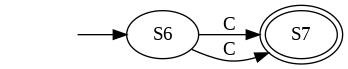

In [49]:
from graphviz import Digraph

def vizualize_NFA(resultNFA):

  gra = Digraph(graph_attr={'rankdir':'LR'})


  for stat in resultNFA.states:
      if(stat.name == resultNFA.start.name):
        gra.node("", _attributes={'shape' : 'none'})
        gra.edge("", stat.name)
      if(stat.name == resultNFA.accepting.name):
        gra.node(stat.name, _attributes={'peripheries' : '2'})
      else:
        gra.node(stat.name)

  for stat in resultNFA.states:
      for edg in stat.out_edges:
          destination = None
          for s in resultNFA.states:
              if edg in s.in_edges:
                  destination = s
                  break
          gra.edge(stat.name, destination.name, label=edg.label)
  gra.format = 'png'
  gra.render('NFA', view = True)
  return gra.source

from IPython.display import Image
vizualize_NFA(nfa)
Image(filename='NFA.png')